<img src="Documents/Spash Image.png" alt="Alternative text" />

# Formula 1 Rookie Drivers: Predicting Future Success

#### Introduction

**Formula 1: The Pinnacle of Motorsport**
- Formula 1 (F1) stands as the apex of motorsports, renowned for its high-speed races, advanced engineering marvels, and the remarkable skill set required of its drivers. As a global spectacle, F1 races are a fusion of intense competition, cutting-edge technology, and strategic prowess.

**The Rookie Challenge**
- For rookie drivers, the initial season in Formula 1 is often a critical juncture that can shape their future in the sport. This phase is rife with challenges as they adapt to the rigors of top-tier racing, learn to handle the demands of advanced F1 machinery, and navigate the complexities of race strategies.

**Project Focus**
- This project delves into the lap time data of rookie drivers, aiming to uncover patterns and insights that could predict their long-term success in Formula 1.
- By leveraging data analytics and machine learning techniques, we seek to transform raw lap time data into predictive insights, offering a data-driven perspective on the potential of emerging F1 talents.

**Significance**
- The findings from this analysis could be pivotal for F1 teams in making informed decisions regarding driver selections and development strategies, ultimately influencing their competitive edge in the sport.

---

#### Background: The Art and Science of Selecting Rookie Drivers in Formula 1

- **The Gamble of Investing in Rookie Drivers**
  - In the world of Formula 1, team success hinges significantly on the capabilities of their drivers. Choosing a rookie driver is a strategic decision laced with both potential and risk. These drivers, often untested at the highest level of motorsport, represent a substantial investment for teams, not only financially but also in terms of resources and time dedicated to their development.

- **The Challenge of Prediction**
  - Predicting the trajectory of a rookie driver's career is a complex task. Factors like adapting to the high-pressure environment of F1, learning team dynamics, and mastering the technologically advanced F1 cars play a crucial role. The inherent unpredictability of a driver's adaptation and growth within the sport adds to the challenge.

- **Objective of the Project**
  - This project aims to demystify this uncertainty by developing a predictive model. The model will analyze various parameters, including lap times and consistency scores, to forecast the potential career trajectory of rookie drivers in F1.
  - The intention is to provide F1 teams with a data-driven tool that can assist in making more informed and strategic decisions when evaluating and selecting rookie talents.

- **A Data-Driven Approach to Driver Selection**
  - By turning to data analytics, we seek to bring objectivity into the process of assessing rookie drivers. This approach aims to quantify potential and performance, offering insights that go beyond subjective evaluation and traditional metrics.

---

### Data Collection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore') # To hide kmeans warnings

# Loading the data into dataframes
df_results = pd.read_csv('./F1_Dataset/results.csv')
df_constructors = pd.read_csv('./F1_Dataset/constructors.csv')
df_drivers = pd.read_csv('./F1_Dataset/drivers.csv')
df_lap_times = pd.read_csv('./F1_Dataset/lap_times.csv')
df_races = pd.read_csv('./F1_Dataset/races.csv')


# Verifying the data is loaded by viewing the first few rows of each dataframe
print(df_results.head())
print('-------------------')

print(df_constructors.head())
print('-------------------')

print(df_drivers.head())
print('-------------------')

print(df_lap_times.head())
print('-------------------')

print(df_races.head())

   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3 

### Data Cleaning

In [2]:
# Creating a function to clean the dataframes
def clean_dataframe(df):
    # Replace all '\N' with None (NaN)
    df = df.replace(r'\\N', np.nan, regex=True)
    
    # Converting date columns to datetime objects and filling missing values with a placeholder date if necessary
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce').fillna(pd.Timestamp('1900-01-01'))

    # Converting any object types that should be numeric
    for col in df.select_dtypes(include=['object']).columns:
        try:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        except ValueError:
            continue  # if conversion fails, continue to next column

    # Filling missing numeric values with a placeholder (e.g., -1)
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        df[col] = df[col].fillna(-1)

    return df

In [3]:
# Creating a function to clean the results dataframe specifically due to the nature of the data
def clean_results(df):
    df = df.replace(r'\\N', pd.NA, regex=True)

    # Converting 'positionText' to a categorical type, preserving the codes as categories
    position_categories = ['R', 'D', 'E', 'W', 'F', 'N']  # add more categories if they exist
    df['positionText'] = pd.Categorical(df['positionText'], categories=position_categories, ordered=False)

    # Interpreting '0' grid position as 'pit lane start', per Kaggle discussions, and createing a new boolean column 'pit_lane_start'
    df['pit_lane_start'] = (df['grid'] == 0)

    return df

In [4]:
# Cleaning the results dataframe
df_results = clean_results(df_results)

# Applying the general cleaning function to the other dataframes
df_constructors = clean_dataframe(df_constructors)
df_drivers = clean_dataframe(df_drivers)
df_lap_times = clean_dataframe(df_lap_times)
df_races = clean_dataframe(df_races)

# Displaying the first few rows of each dataframe to confirm the cleaning was successful
print(df_results.head())
print(df_constructors.head())
print(df_drivers.head())
print(df_lap_times.head())
print(df_races.head())

   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0          NaN              1    10.0    58  1:34:50.616      5690616   
1          NaN              2     8.0    58       +5.478      5696094   
2          NaN              3     6.0    58       +8.163      5698779   
3          NaN              4     5.0    58      +17.181      5707797   
4          NaN              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  pit_lane_start  
0         39    2       1:27.452         218.300         1     

### Data Integration

In [5]:
# Merging results with races on 'raceId'
df_merged_results_races = pd.merge(df_results, df_races, on='raceId', suffixes=('_result', '_race'))

# Merging the new dataframe with constructors on 'constructorId'
df_merged_results_races_constructors = pd.merge(df_merged_results_races, df_constructors, on='constructorId', suffixes=('', '_constructor'))

# Merging the new dataframe with drivers on 'driverId'
df_final_merged = pd.merge(df_merged_results_races_constructors, df_drivers, on='driverId', suffixes=('', '_driver'))

# Displaying the first few rows of the final merged dataframe to verify the integration
print(df_final_merged.head())

   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1        27      19         1              1     22     9        5   
2        57      20         1              1     22     3       13   
3        69      21         1              1     22     5        3   
4        90      22         1              1     22     3        2   

  positionText  positionOrder  points  ...  nationality  \
0          NaN              1    10.0  ...      British   
1          NaN              5     4.0  ...      British   
2          NaN             13     0.0  ...      British   
3          NaN              3     6.0  ...      British   
4          NaN              2     8.0  ...      British   

                        url_constructor driverRef number_driver code forename  \
0  http://en.wikipedia.org/wiki/McLaren  hamilton          44.0  HAM    Lewis   
1  http://en.wikipedia.org/wiki/McLaren  hamilton          44.

### Feature Engineering

#### Rookie Status

A rookie will be defined as their first year in Formula 1, regardless of length. To be able to identify a rookie's first year, we will need to create a column that indicates the driver's first year in Formula 1. This can be done by retrieving the minimum year from the `year` column in df_races for each driver.

In [6]:
# Merging df_results with df_races to get the year for each result
df_results_with_year = pd.merge(df_results, df_races, on='raceId')

# Finding the first year each driver raced
df_first_year = df_results_with_year.groupby('driverId')['year'].min().reset_index()
df_first_year.columns = ['driverId', 'firstYear']

# Adding the first year information to df_results_with_year
df_results_with_year = pd.merge(df_results_with_year, df_first_year, on='driverId', how='left')

# Creating the is_rookie feature
df_results_with_year['is_rookie'] = (df_results_with_year['year'] == df_results_with_year['firstYear']).astype(int)


In [7]:
df_results_with_year.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time,firstYear,is_rookie
0,1,18,1,1,22,1,1,NaN,1,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,0
1,2,18,2,2,3,5,2,NaN,2,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,0
2,3,18,3,3,7,7,3,NaN,3,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006,0
3,4,18,4,4,5,11,4,NaN,4,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001,0
4,5,18,5,1,23,3,5,NaN,5,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007,0


#### Segmented Normalized Lap Times

In an effort to deeply analyze the lap times of rookie Formula 1 drivers, I'll introduce a feature called "Segmented Normalized Lap Times". This feature aims to eliminate the variability in lap times caused by differing track lengths, conditions, and other external factors. I'll achieve this by dividing each race into three segments and calculating the average lap time for each segment. We then normalize the individual lap times based on this average. This provides us with a standardized measure of performance that is comparable across different races and conditions.


In [8]:
# Calculating segmented normalized lap times

# Determine the total number of laps for each race
total_laps_per_race = df_lap_times.groupby('raceId')['lap'].max().reset_index()
total_laps_per_race.rename(columns={'lap': 'total_laps'}, inplace=True)

# Merge this information back into a new dataframe for segmented lap times
df_lap_times_segmented = pd.merge(df_lap_times, total_laps_per_race, on='raceId')

# Divide each race into 3 segments
df_lap_times_segmented['segment_id'] = np.ceil(3 * df_lap_times_segmented['lap'] / df_lap_times_segmented['total_laps']).astype(int)

# Calculate average lap time for each segment in each race
avg_lap_time_by_segment = df_lap_times_segmented.groupby(['raceId', 'segment_id'])['milliseconds'].mean().reset_index()
avg_lap_time_by_segment.rename(columns={'milliseconds': 'milliseconds_avg'}, inplace=True)

# Merge this back into the df_lap_times_segmented dataframe
df_lap_times_segmented = pd.merge(df_lap_times_segmented, avg_lap_time_by_segment, on=['raceId', 'segment_id'])

# Calculate the normalized lap time
df_lap_times_segmented['normalized_time'] = df_lap_times_segmented['milliseconds'] / df_lap_times_segmented['milliseconds_avg']

# Aggregate to get average normalized time for each driver in each race
avg_normalized_time = df_lap_times_segmented.groupby(['driverId', 'raceId'])['normalized_time'].mean().reset_index()

#### Clustered Lap Times

In addition to the segmented normalized times, we are introducing a new feature called "Clustered Lap Times". This feature will categorize each lap time into one of three categories: "Fast", "Medium", or "Slow". This classification is based on a K-means clustering algorithm. We then calculate the proportion of laps that fall into each of these categories for each driver in each race. This will help us understand the consistency and adaptability of drivers during races.

In [9]:
# Initializing KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# Creating an empty dataframe to store the results
df_clustered_laptimes = pd.DataFrame()

# Looping through each race to perform clustering
for race in df_lap_times['raceId'].unique():
    temp_df = df_lap_times[df_lap_times['raceId'] == race].copy()
    
    # Reshaping the data to fit the KMeans model
    lap_times = np.array(temp_df['milliseconds']).reshape(-1, 1)
    
    # Fitting the KMeans model
    kmeans.fit(lap_times)
    
    # Getting the cluster labels (0, 1, 2)
    labels = kmeans.labels_
    
    # Mapping numeric cluster labels to human-readable labels
    label_dict = {0: 'Medium', 1: 'Fast', 2: 'Slow'}
    mapped_labels = [label_dict[label] for label in labels]
    
    # Adding the labels to the temporary dataframe
    temp_df.loc[:, 'cluster_label'] = mapped_labels
    
    # Appending to the results dataframe
    df_clustered_laptimes = pd.concat([df_clustered_laptimes, temp_df], ignore_index=True)

# Calculating the proportion of each label for each driver in each race
df_cluster_proportions = df_clustered_laptimes.groupby(['raceId', 'driverId', 'cluster_label']).size().unstack(fill_value=0)
df_cluster_proportions = df_cluster_proportions.div(df_cluster_proportions.sum(axis=1), axis=0).reset_index()

df_cluster_proportions

cluster_label,raceId,driverId,Fast,Medium,Slow
0,1,1,0.810345,0.086207,0.103448
1,1,2,0.810345,0.051724,0.137931
2,1,3,0.793103,0.068966,0.137931
3,1,4,0.827586,0.086207,0.086207
4,1,6,0.941176,0.000000,0.058824
...,...,...,...,...,...
10379,1110,847,0.636364,0.295455,0.068182
10380,1110,848,0.545455,0.386364,0.068182
10381,1110,852,0.659091,0.295455,0.045455
10382,1110,855,0.545455,0.386364,0.068182


#### Consistency Score Using Coefficient of Variation (CV)

To measure the consistency of rookie Formula 1 drivers, I'll introduce a feature called `consistency_score_cv`. This score is calculated using the Coefficient of Variation (CV), which is the ratio of the standard deviation to the mean of lap times for each driver in each race. CV serves as a normalized measure of variability, allowing us to compare consistency across different races and drivers. A lower CV implies higher consistency, making it a valuable metric for assessing a driver's potential for long-term success in Formula 1.

In [10]:
# Calculating new consistency_score using Coefficient of Variation (CV)

# Calculate mean and standard deviation of lap times for each driver in each race
lap_time_stats = df_lap_times.groupby(['driverId', 'raceId']).agg(
    mean_time=pd.NamedAgg(column='milliseconds', aggfunc='mean'),
    std_dev_time=pd.NamedAgg(column='milliseconds', aggfunc='std')
).reset_index()

# Calculate Coefficient of Variation (CV)
lap_time_stats['consistency_score_cv'] = lap_time_stats['std_dev_time'] / lap_time_stats['mean_time']

In [11]:
# Merging avg_normalized_time into df_results
df_results_with_features = pd.merge(df_results, avg_normalized_time, on=['driverId', 'raceId'], how='left')

# Merging consistency_score_cv into df_results
df_results_with_features = pd.merge(df_results_with_features, lap_time_stats[['driverId', 'raceId', 'consistency_score_cv']], on=['driverId', 'raceId'], how='left')

# Merging the new clustered lap times feature into the main results dataframe
df_results_with_features = pd.merge(df_results_with_features, df_cluster_proportions, on=['driverId', 'raceId'], how='left')

# Merging df_constructors to get constructor name
df_results_with_features = pd.merge(df_results_with_features, df_constructors[['constructorId', 'name']], left_on='constructorId', right_on='constructorId', how='left')
df_results_with_features.rename(columns={'name': 'constructor_name'}, inplace=True)


# Merging into df_results_with_features
df_rookie_feature = df_results_with_year[['driverId', 'raceId', 'is_rookie']]
df_results_with_features = pd.merge(df_results_with_features, df_rookie_feature, on=['driverId', 'raceId'], how='left')


# Displaying the first few rows for reference
print(df_results_with_features.head())
df_results_with_features.info()

   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  ...  fastestLapSpeed statusId  \
0          NaN              1    10.0  ...          218.300        1   
1          NaN              2     8.0  ...          217.586        1   
2          NaN              3     6.0  ...          216.719        1   
3          NaN              4     5.0  ...          215.464        1   
4          NaN              5     4.0  ...          218.385        1   

  pit_lane_start normalized_time consistency_score_cv      Fast    Medium  \
0          False        0.990231             0.213938  0.103448  0.79

#### Feature Engineering: Summary


1. Rookie Identification:
   * A rookie’s first year is defined as their initial season in Formula 1, regardless of its duration.
   * A new column will be created to flag a driver’s first year by extracting the minimum year from the year column in df_races for each driver, establishing the baseline for performance analysis.
2. Segmented Normalized Lap Times:
   * Calculated by normalizing the lap time of each driver by the average lap time for the respective segment of the race.
   * Enables comparison of performance across different races and segments.
3. Clustered Lap Time Analysis:
   * Lap times are classified into three categories using a K-means clustering algorithm: "Fast," "Medium," or "Slow."
   * The proportion of laps in each category is calculated for individual drivers in each race, offering insights into their speed consistency and adaptability under varying race conditions.
4. Consistency Score (CV):
   * Measured as the Coefficient of Variation (CV), which is the standard deviation divided by the mean lap time for each driver in each race.
   * Provides a normalized measure of a driver's lap time variability.

### Exploratory Data Analysis (EDA)

Now that we're wrapped up with feature engineering, let's set a plan for the EDA to follow on this merged dataset.

EDA Plan:
* *Summary Statistics*: Generate descriptive statistics for the new features (consistency_score_cv and normalized_time).
* *Correlation Analysis*: Examine how these new features correlate with each other and potentially with other variables.
* *Missing Values*: Check for missing values in these new features and decide how to handle them.

In [12]:
# Summary statistics for the new features
summary_stats_new = df_results_with_features[['is_rookie', 'consistency_score_cv', 'normalized_time', 'Fast', 'Medium', 'Slow']].describe()
summary_stats_new

,is_rookie,consistency_score_cv,normalized_time,Fast,Medium,Slow
count,26274.000000,10272.000000,10384.000000,10384.000000,10384.000000,10384.000000
mean,0.149121,0.166906,1.006959,0.146940,0.691271,0.161789
std,0.356214,0.390434,0.088809,0.257399,0.332576,0.254254
min,0.000000,0.000876,0.394487,0.000000,0.000000,0.000000
25%,0.000000,0.045129,0.990416,0.023256,0.500000,0.018868
50%,0.000000,0.070617,0.998707,0.045455,0.865385,0.053571
75%,0.000000,0.133918,1.008409,0.093023,0.932203,0.142857
max,1.000000,4.218630,5.494057,1.000000,1.000000,1.000000


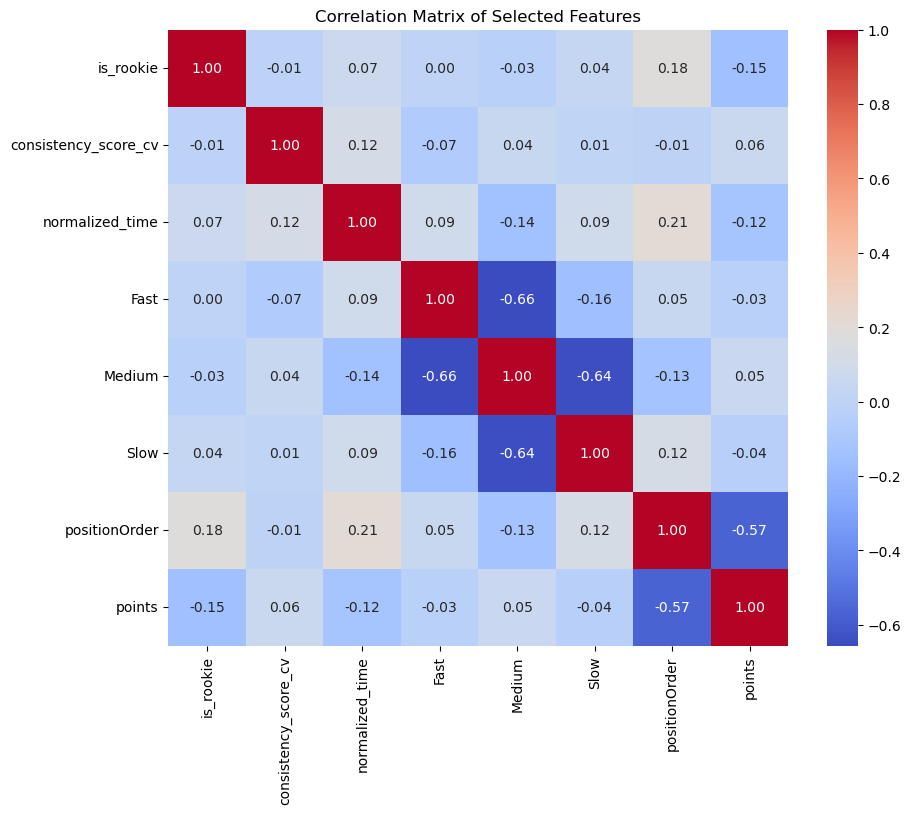

In [13]:
# Correlation matrix for the new features
correlation_matrix = df_results_with_features[['is_rookie', 'consistency_score_cv', 'normalized_time', 'Fast', 'Medium', 'Slow', 'positionOrder', 'points']].corr()

# Creating a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [14]:
def simple_histogram(column_name, title, xlabel, color):
   plt.hist(df_results_with_features[df_results_with_features['is_rookie'] == 1][column_name], 
             bins=20, alpha=0.5, label='Rookie', color=color, edgecolor='black')
   plt.hist(df_results_with_features[df_results_with_features['is_rookie'] == 0][column_name], 
             bins=20, alpha=0.5, label='Non-Rookie', color='grey', edgecolor='black')
   plt.title(title)
   plt.xlabel(xlabel)
   plt.ylabel('Frequency')
   plt.legend(loc='upper right')

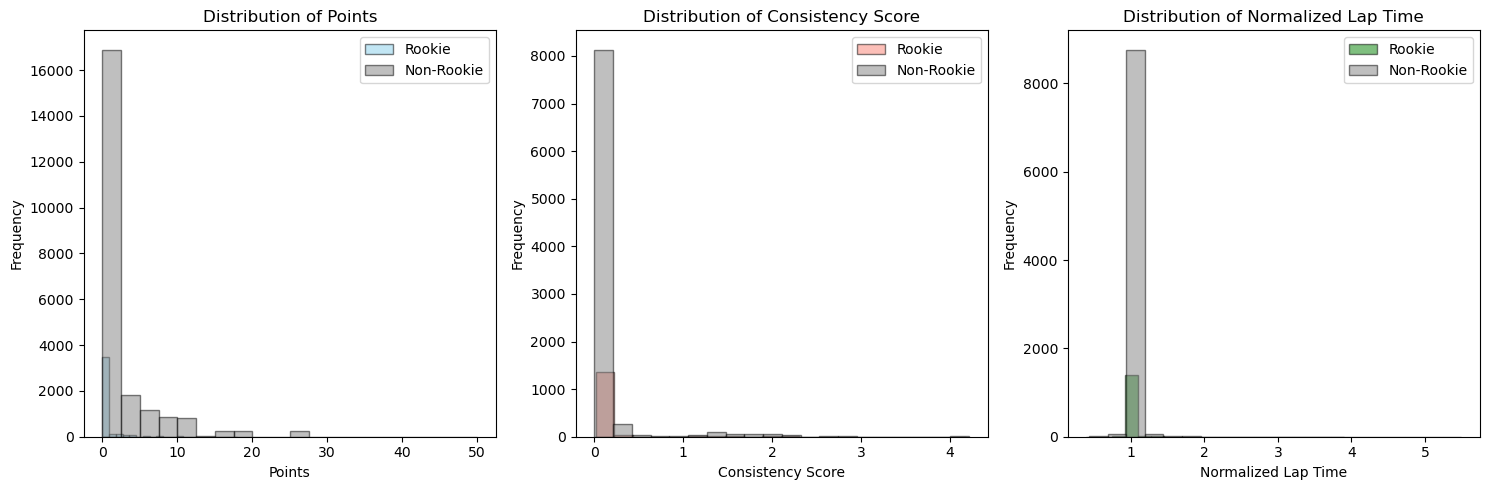

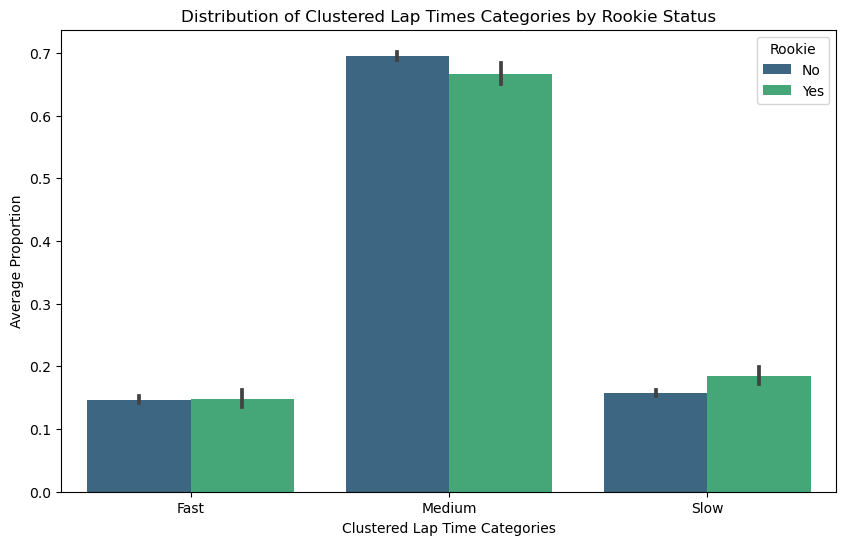

In [15]:
# Plotting histograms
plt.figure(figsize=(15, 5))

# Plotting 'points'
plt.subplot(1, 3, 1)
simple_histogram('points', 'Distribution of Points', 'Points', 'skyblue')

# Plotting 'consistency_score'
plt.subplot(1, 3, 2)
simple_histogram('consistency_score_cv', 'Distribution of Consistency Score', 'Consistency Score', 'salmon')

# Plotting 'normalized_lap_time'
plt.subplot(1, 3, 3)
simple_histogram('normalized_time', 'Distribution of Normalized Lap Time', 'Normalized Lap Time', 'green')

plt.tight_layout()
plt.show()


# Clustered lap times by rookie status

# Preparing the data
melted_data = df_results_with_features.melt(id_vars=['is_rookie'], value_vars=['Fast', 'Medium', 'Slow'], var_name='Speed', value_name='Average Proportion')

# Creating the Grouped Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Speed', y='Average Proportion', hue='is_rookie', data=melted_data, palette='viridis')

# Relabeling the legend and axes
plt.title('Distribution of Clustered Lap Times Categories by Rookie Status')
plt.xlabel('Clustered Lap Time Categories')
plt.ylabel('Average Proportion')

# Changing legend labels
legend_labels, _= plt.gca().get_legend_handles_labels()
plt.legend(legend_labels, ['No', 'Yes'], title='Rookie')

plt.show()

In [16]:
# Checking for missing values in the new features and other potentially important columns
missing_values_count = df_results_with_features[['is_rookie', 'consistency_score_cv', 'normalized_time', 'Fast', 'Medium', 'Slow', 'positionOrder', 'points']].isnull().sum()
missing_values_count

is_rookie                   0
consistency_score_cv    16002
normalized_time         15890
Fast                    15890
Medium                  15890
Slow                    15890
positionOrder               0
points                      0
dtype: int64

#### Missing Values:

- All engineered features, aside from the is_rookie one-hot encode, contain missing values.

#### Options for handling:

1. **Imputation**: Replace missing values with mean, median, or some other statistical measure.
2. **Deletion**: Remove rows with missing values.
3. **Investigation**: Find out why the data is missing and see if it can be retrieved.

#### Thoughts: 
Imputation isn't appropriate to do on this dataset - providing false normalized time or consistency_score could potentially invalidate the model's results. Due to the variability of F1, these values may be appropriately missing. Let's explore this data to verify that assumption.

In [17]:
# Investigating missing values by identifying the races and drivers where these occur
missing_consistency = df_results_with_features[df_results_with_features['consistency_score_cv'].isnull()][['raceId', 'driverId']]
missing_normalized = df_results_with_features[df_results_with_features['normalized_time'].isnull()][['raceId', 'driverId']]
missing_fast = df_results_with_features[df_results_with_features['Fast'].isnull()][['raceId', 'driverId']]
missing_medium = df_results_with_features[df_results_with_features['Medium'].isnull()][['raceId', 'driverId']]
missing_slow = df_results_with_features[df_results_with_features['Slow'].isnull()][['raceId', 'driverId']]

# Checking if the missing values for both features occur for the same set of raceId and driverId
common_missing_values = pd.merge(missing_consistency, missing_normalized, on=['raceId', 'driverId'], how='inner')
common_missing_values = pd.merge(common_missing_values, missing_fast, on=['raceId', 'driverId'], how='inner')
common_missing_values = pd.merge(common_missing_values, missing_medium, on=['raceId', 'driverId'], how='inner')
common_missing_values = pd.merge(common_missing_values, missing_slow, on=['raceId', 'driverId'], how='inner')

# Counting the number of common missing values
common_missing_count = common_missing_values.shape[0]

# Counting the number of unique races and drivers where missing values occur
unique_missing_races = common_missing_values['raceId'].nunique()
unique_missing_drivers = common_missing_values['driverId'].nunique()

common_missing_count, unique_missing_races, unique_missing_drivers

(450710, 806, 830)

#### Missing Value Investigation

- A total of 450,710 values instances have missing values for the engineered features.
- These missing values occur across 806 unique races and involve 830 unique drivers.
- The missing values are likely due to drivers not completing all laps in a race for various reasons, such as mechanical failures, accidents, etc.

In [18]:
# Investigating a few instances where missing values occur
# We'll select a few raceId and driverId combinations from the common_missing_values dataframe to explore further
sample_missing_values = common_missing_values.sample(50, random_state=42)

# Merging these samples with the original df_lap_times to see how many laps these drivers completed in these races
sample_lap_data = pd.merge(sample_missing_values, df_lap_times, on=['raceId', 'driverId'], how='left')

# Counting the number of laps completed for these samples
laps_completed = sample_lap_data.groupby(['raceId', 'driverId'])['lap'].max().reset_index()
laps_completed.rename(columns={'lap': 'laps_completed'}, inplace=True)

# Merging to get the total number of laps for these races
laps_completed = pd.merge(laps_completed, total_laps_per_race, on='raceId', how='left')

# Calculating the percentage of laps completed by these drivers in these races
laps_completed['percentage_completed'] = (laps_completed['laps_completed'] / laps_completed['total_laps']) * 100

laps_completed

,raceId,driverId,laps_completed,total_laps,percentage_completed
0,287,77,NaN,NaN,NaN
1,287,100,NaN,NaN,NaN
2,577,232,NaN,NaN,NaN
3,772,601,NaN,NaN,NaN
4,776,581,NaN,NaN,NaN
5,788,475,NaN,NaN,NaN
6,788,624,NaN,NaN,NaN
7,792,427,NaN,NaN,NaN
8,792,501,NaN,NaN,NaN
9,792,554,NaN,NaN,NaN


#### Missing Value Verification

- Random sampling of 50 instances with missing values was performed.
- None of the sampled drivers completed any laps in those specific races.
- This verifies the assumption that missing values are likely due to drivers not completing all laps in a race for various reasons, such as mechanical failures, accidents, etc.

In [19]:
# Deleting rows with missing values
df_results_with_features_cleaned = df_results_with_features.dropna(subset=['is_rookie', 'consistency_score_cv', 'normalized_time', 'Fast', 'Medium', 'Slow'])

# Checking the new shape of the dataframe
new_shape = df_results_with_features_cleaned.shape
new_shape

(10272, 26)

#### Missing Value Handling

- After verification, it's confirmed that missing values for the engineered features is primarily due to drivers not completing races.
- These rows have been deleted from the dataset for the following reasons:
  1. The missing data is not random, as we observed prior.
  2. Imputing such missing data could introduce inaccuracies in the analysis.

#### EDA: Summary
consistency_score_cv and normalized_time are weakly correlated with each other, indicating they capture different aspects of performance.
Both of these new features show low correlation with positionOrder and points, suggesting they could provide additional information in predicting driver success.

The remaining features provide additional context to the analysis being done, which will be useful in the modeling phase.

-----

### Feature Selection

For this project, we're wanting to see which rookies are going to be more successful over time. Success for the team can boil down to points obtained by the driver - the more points they're able to reliably gather each race, the more positions the constructor (team) will rise in the championship standings. As such, the main target for any correlation should be the points variable.

In [20]:
# Calculating the Pearson correlation coefficient between the candidate features and the target variable 'points'
correlation_with_target = df_results_with_features_cleaned[['is_rookie', 'normalized_time', 'consistency_score_cv', 'Fast', 'Medium', 'Slow', 'positionOrder', 'constructorId', 'points']].corr()['points']
correlation_with_target = correlation_with_target.drop('points')  # Dropping the correlation of 'points' with itself
correlation_with_target

is_rookie              -0.191460
normalized_time        -0.147085
consistency_score_cv    0.058720
Fast                   -0.024041
Medium                  0.047110
Slow                   -0.037560
positionOrder          -0.718230
constructorId           0.012974
Name: points, dtype: float64

#### Information
- Pearson correlation coefficients were calculated for each candidate feature against the target variable `points`.
  1. `positionOrder`: -0.718
  2. `is_rookie`: -0.191
  3. `normalized_time`: -0.147
  4. `Slow`: -0.038
  6. `Fast`: -0.024
  7. `constructorId`: 0.013
  5. `Medium`: 0.047
  8. `consistency_score_cv`: 0.059

- `positionOrder` shows a strong negative correlation with `points`, making it a highly relevant feature.
- `is_rookie` and `normalized_time`  show moderate negative correlation with `points`, making them relevant features.
- `consistency_score_cv`, `constructorId`, `Fast`, `Medium`, and `Slow` shows minimal correlation with `points`.

#### Addressing Redundancy in Feature Selection

- In Formula 1, `points` are distributed on a sliding scale based on the position of the driver at the end of the race. The breakdown, as of the 2023 season, is as follows:
  - First place gets 25 points, second gets 18, scaling down to 1 point for 10th.
  - All other positions lower than 10th receive no points.
- Because of this, while the strong correlation between `positionOrder` and `points` is expected, its validation serves as a sanity check for the model.
- Such validation can be particularly useful for comprehensive and robust analysis, even if the relationship is already known.

In [21]:
# Define the features and the target variable
X = df_results_with_features_cleaned[['is_rookie', 'normalized_time', 'consistency_score_cv', 'Fast', 'Medium', 'Slow', 'positionOrder', 'constructorId']]
y = df_results_with_features_cleaned['points']

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X, y)

# Get the feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)
feature_importances_df

,Feature,Importance
6,positionOrder,0.761532
7,constructorId,0.126733
2,consistency_score_cv,0.030419
4,Medium,0.024332
1,normalized_time,0.023554
3,Fast,0.017953
5,Slow,0.015000
0,is_rookie,0.000477


#### Feature Importance (Random Forest)

- A Random Forest Regressor model was used to evaluate the importance of each feature for predicting `points`.
  1. `positionOrder`: 0.762
  2. `constructorId`: 0.127
  4. `consistency_score_cv`: 0.030
  3. `Medium`: 0.024
  5. `normalized_time`: 0.024
  6. `Fast`: 0.018
  7. `Slow`: 0.015
  8. `is_rookie`: 0.000

- `positionOrder` has the highest importance, followed by `constructorId`, `Medium`, `consistency_score_cv`, `normalized_time`, `Fast`, `Slow`, and `is_rookie`.
- All features show some level of importance, suggesting that they should be considered in the modeling phase.

In [22]:
from sklearn.model_selection import train_test_split

# Splitting the data into training, validation, and test sets
# First, we'll split the data into training (70%) and temporary (30%) sets
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Then, we'll split the temporary set into validation (15%) and test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Checking the shapes to confirm the splits
X_train_temp.shape, X_val.shape, X_test.shape

((7190, 8), (1541, 8), (1541, 8))

#### Algorithm Selection
This project employs the Random Forest algorithm for predictive modeling. Random Forest is chosen for its ability to handle large data sets with higher dimensionality and its ability to handle missing values. It's also robust to outliers, which are common in sports analytics.

#### Data Splitting

- The dataset was split into training, validation, and test sets.
- Number of samples in each set:
  - **Training set**: 7,190 samples
  - **Validation set**: 1,541 samples
  - **Test set**: 1,541 samples

- The splitting ratios used were 70% for training, 15% for validation, and 15% for testing.

### Model Selection


In [23]:
# Initializing the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fitting the model on the training data
rf_model.fit(X_train_temp, y_train_temp)

# Making predictions on the validation set
y_val_pred_rf = rf_model.predict(X_val)

# Calculating the performance metrics for the model on the validation set
mse_rf = mean_squared_error(y_val, y_val_pred_rf)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_rf = r2_score(y_val, y_val_pred_rf)

mse_rf, mae_rf, r2_rf

(3.6683474367293964, 0.7704218040233614, 0.8925098191243039)

#### Models Tried:

1. **Linear Regression**: Used as a baseline model to provide a point of reference for other models (for visual clarity, this was removed after obtaining the baseline data).
2. **Random Forest Regressor**: Chosen as a more complex alternative capable of capturing intricate relationships in the data.

#### Comparative Performance:

- **Linear Regression**
  - **Mean Squared Error (MSE)**: 15.81
  - **Mean Absolute Error (MAE)**: 3.135
  - **R-Squared ($R^2$)**: 0.537

<br>

- **Random Forest Regressor**
  - **Mean Squared Error (MSE)**: 3.668
  - **Mean Absolute Error (MAE)**: 0.770
  - **R-Squared ($R^2$)**: 0.893

#### Decision:

- Random Forest Regressor shows a significant improvement over Linear Regression in every metric, explaining approximately 89.3% of the variance in `points`.
- Given its superior performance, I've decided to proceed with Random Forest Regressor for further model tuning and evaluations.


In [24]:
# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Initializing the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)

# Initializing the Grid Search with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                                    cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

# Fitting the Grid Search to the data
grid_search.fit(X_train_temp, y_train_temp)

# Getting the best parameters and the corresponding best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

best_params, best_score

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


({'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.7655513237482209)

#### Hyperparameter Tuning - Random Forest

- An extensive Grid Search was conducted to fine-tune the Random Forest model.
- The best hyperparameters obtained are:
  - **Max Depth**: None
  - **Min Samples Leaf**: 1
  - **Min Samples Split**: 2
  - **Number of Estimators**: 200

In [25]:
# Initializing the Random Forest Regressor model with the best hyperparameters
final_rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1, 
    random_state=42)

# Fitting the final model on the training data
final_rf_model.fit(X_train_temp, y_train_temp)

# Making predictions on the test set
y_test_pred = final_rf_model.predict(X_test)

# Calculating the performance metrics for the model on the test set
final_mse = mean_squared_error(y_test, y_test_pred)
final_mae = mean_absolute_error(y_test, y_test_pred)
final_r2 = r2_score(y_test, y_test_pred)

final_mse, final_mae, final_r2

(4.665170323653472, 0.8633241401687217, 0.8703789390510402)

#### Final Model Evaluation

- The final Random Forest model was evaluated on a test set containing 1,541 samples.
- Performance metrics on the test set:
  - **Mean Squared Error (MSE)**: 4.665
    - A lower MSE indicates a better fit to the data. The MSE of 4.665 signifies that the model has a relatively low error rate in predicting the `points`.
  - **Mean Absolute Error (MAE)**: 0.863
    - MAE provides an idea of how far off the predictions were from the actual outcome. A MAE of 0.863 means the average prediction was that much away from the actual `points`, indicating a reasonable level of accuracy.
  - **R-Squared ($R^2$)**: 0.870
    - The $R^2$ value indicates that the model explains approximately 87% of the variance in `points`. The higher the $R^2$ value, the better the model showcases the relationship between the features and the target variable.

- Comparative Insights:
  - The model's performance is strong but slightly lower than on the validation set, which is a typical observation.

---

### Interpretation, Methodology, and Conclusion

#### Interpretation

- The final Random Forest model explains approximately 87% of the variance in `points` for rookie drivers.
- This strong performance suggests that the engineered features are significant predictors of a rookie driver's success in Formula 1.

#### Methodology
This project follows a structured data analytics workflow, which includes the following steps:

1. **Data Collection**: The initial dataset was sourced from publicly available Formula 1 statistics, via Kaggle.
2. **Data Cleaning and Preprocessing**: Extensive cleaning was done to handle missing values and outliers.
3. **Feature Engineering**: New features such as `consistency_score` and `normalized_time` were engineered to enhance the model's predictive power.
4. **Model Selection**: A Random Forest Regressor was chosen after evaluating its performance against other algorithms.
5. **Hyperparameter Tuning**: GridSearchCV was employed for exhaustive hyperparameter tuning.
6. **Model Evaluation**: The final model was evaluated using Mean Squared Error, Mean Absolute Error, and R-Squared scores and comparing their variances from both the baseline metrics, before hypertuning, as well as comparing the metrics to one another.

#### Conclusion
The predictive model built demonstrates a strong ability to forecast the future success of rookie Formula 1 drivers based on their first season's performance. The project's research question aimed to explore how the progression of lap times for rookie drivers correlates with their long-term success.
- The analysis and the final model indicate that lap times and other features like consistency score are strong predictors of a rookie driver's future success in Formula 1, as measured by the points they accumulate.
 While the model's $R^2$ score of 0.870 is promising, there's always room for improvement, especially in the dynamic and complex world of Formula 1.

#### Potential Future Enhancements / Takeaways
1. **Additional Data**: Incorporating more features, such as weather conditions, track type, or tyre type, could potentially improve the model. Unfortunately, this data wasn't available in the public datasets.
2. **Alternative Algorithms**: While Random Forest showed strong performance, other algorithms like Gradient Boosting or Neural Networks could be explored in future work.